In [1]:
%load_ext autoreload
import uproot as ut
import awkward as ak
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
from skimage.measure import LineModelND, ransac
import scipy
import numpy as np
import re
import sympy as sp
import math
import vector

from tqdm import tqdm
import timeit

from utils import *
%autoreload 2

In [2]:
ak.to_list(ak.combinations([list(range(6))],2))

[[(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, 3),
  (2, 4),
  (2, 5),
  (3, 4),
  (3, 5),
  (4, 5)]]

In [3]:
def get_all_triH_njet_combs(njet=6):
    if njet < 6: return []
    
    jets = list(range(njet))
    j0 = jets[0]
    triH_combs = [ [j0,j1] for j1 in jets[1:] ]
    triH_combs = [ comb+[j2] for comb in triH_combs for j2 in jets if j2 not in comb]
    triH_combs = [ comb+[j3] for comb in triH_combs for j3 in jets if j3 not in comb and j3>comb[-1]]
    triH_combs = [ comb+[j4] for comb in triH_combs for j4 in jets if j4 not in comb and j4>comb[-2]]
    triH_combs = [ comb+[j5] for comb in triH_combs for j5 in jets if j5 not in comb and j5>comb[-1]]
    return triH_combs

In [4]:
triH_combs = get_all_triH_njet_combs()

In [5]:
triH_combs

[[0, 1, 2, 3, 4, 5],
 [0, 1, 2, 4, 3, 5],
 [0, 1, 2, 5, 3, 4],
 [0, 2, 1, 3, 4, 5],
 [0, 2, 1, 4, 3, 5],
 [0, 2, 1, 5, 3, 4],
 [0, 3, 1, 2, 4, 5],
 [0, 3, 1, 4, 2, 5],
 [0, 3, 1, 5, 2, 4],
 [0, 4, 1, 2, 3, 5],
 [0, 4, 1, 3, 2, 5],
 [0, 4, 1, 5, 2, 3],
 [0, 5, 1, 2, 3, 4],
 [0, 5, 1, 3, 2, 4],
 [0, 5, 1, 4, 2, 3]]

In [6]:
tree = Tree(fc.sr.NMSSM_MX_700_MY_400.replace("SR","SR/tmp"))
selection = Selection(tree,njets=6)
selection.build_extra_collections()
selection = Selection(tree,njets=6,mask=selection.nsixb_selected==6)

In [7]:
triH_tru = ak.argsort(selection["jet_signalId"],axis=-1)

In [8]:
def pair_adjacent_jets(pt,eta,phi,m):
    j0,j1,j2,j3,j4,j5 = [ vector.obj(pt=pt[:,ijet],eta=eta[:,ijet],phi=phi[:,ijet],m=m[:,ijet]) for ijet in range(6) ]
    
    h0 = j0+j1
    h1 = j2+j3
    h2 = j4+j5
    
    return h0,h1,h2

In [9]:
def use_triH_comb(selection,triH_comb):
    if type(triH_comb) == list:
        triH_comb = ak.Array([triH_comb]*selection.nevents)
    pt =  selection["jet_pt"][triH_comb]
    eta = selection["jet_eta"][triH_comb]
    phi = selection["jet_phi"][triH_comb]
    m = selection["jet_m"][triH_comb]
    return pair_adjacent_jets(pt,eta,phi,m)

In [10]:
def get_m_vec(selection,triH_comb):
    h0,h1,h2 = use_triH_comb(selection,triH_comb)
    m0,m1,m2 = h0.m,h1.m,h2.m
    m_vec = vector.obj(x=m0,y=m1,z=m2)
    return m_vec

In [11]:
m_vec = get_m_vec(selection,triH_tru)
x,y,z = [ak.to_numpy(r) for r in (m_vec.x,m_vec.y,m_vec.z)]

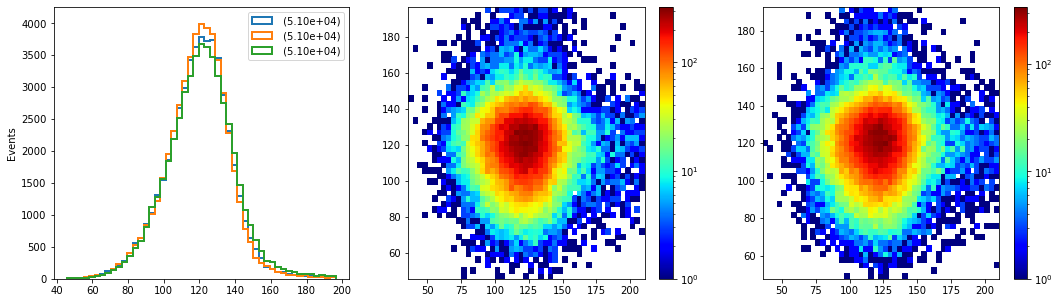

In [12]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
hist_multi([x,y,z],figax=(fig,axs[0])); hist2d_simple(z,x,figax=(fig,axs[1])); hist2d_simple(z,y,figax=(fig,axs[2]));

In [13]:
r_vec = lambda phi,theta : vector.obj(rho=1,phi=phi,theta=theta)
d_hhh_inv = lambda angles : -1/ak.mean(m_vec.cross(r_vec(angles[0],angles[1])).mag,axis=-1)
x_min = scipy.optimize.fmin(d_hhh_inv,[np.pi/4,np.pi/2])

Optimization terminated successfully.
         Current function value: -0.031823
         Iterations: 36
         Function evaluations: 68


In [14]:
mean_phi,mean_theta = x_min
print(mean_phi,mean_theta)

0.7824843735730134 0.9604760692118302


In [15]:
def find_triH_sys(selection,phi=mean_phi,theta=mean_theta):
    r_vec = vector.obj(rho=1,phi=phi,theta=theta)
    triH_m_combs = [ get_m_vec(selection,triH_comb) for triH_comb in triH_combs ]

    triH_m_combs_d = np.array([ triH_m.cross(r_vec).mag for triH_m in triH_m_combs ]).T

    best_triH_comb_id = np.argmin(triH_m_combs_d,axis=-1)
    best_triH_comb = ak.broadcast_arrays(np.array(triH_combs)[best_triH_comb_id],selection["jet_pt"][:,:6])[0]

    best_triH_m = get_m_vec(selection,best_triH_comb)
    selection.extend(H_m=ak.concatenate( [m[:,np.newaxis] for m in [best_triH_m.x,best_triH_m.y,best_triH_m.z]],axis=-1) )
    return best_triH_m.x,best_triH_m.y,best_triH_m.z

In [16]:
tx,ty,tz = find_triH_sys(selection)

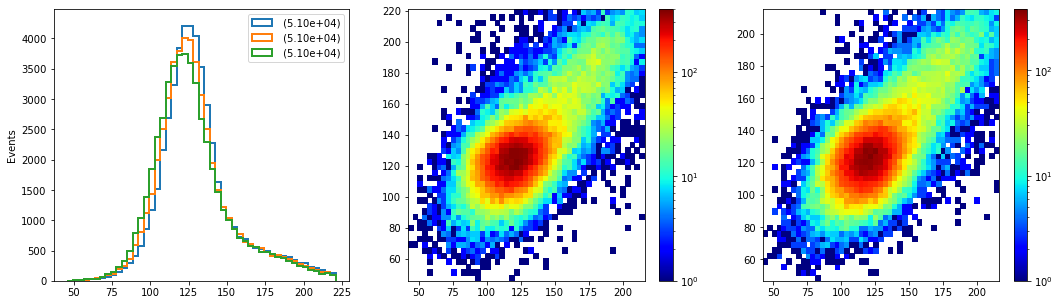

In [17]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
hist_multi([tx,ty,tz],figax=(fig,axs[0])); hist2d_simple(tz,tx,figax=(fig,axs[1])); hist2d_simple(tz,ty,figax=(fig,axs[2]));

In [18]:
selection_full = Selection(tree,njets=6)

In [19]:
tx,ty,tz = find_triH_sys(selection_full)

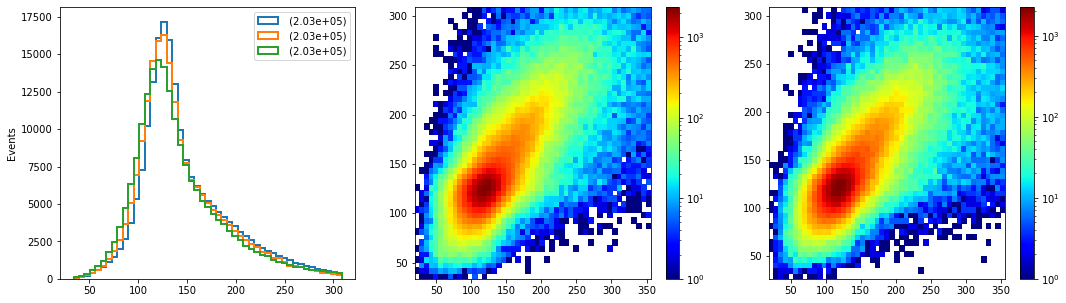

In [20]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
hist_multi([tx,ty,tz],figax=(fig,axs[0])); hist2d_simple(tz,tx,figax=(fig,axs[1])); hist2d_simple(tz,ty,figax=(fig,axs[2]));

In [21]:
qcd_tree = Tree([ qcd.replace("SR","SR/tmp") for qcd in fc.sr.QCD_B_List ])

In [22]:
tx,ty,tz = find_triH_sys(qcd_tree)

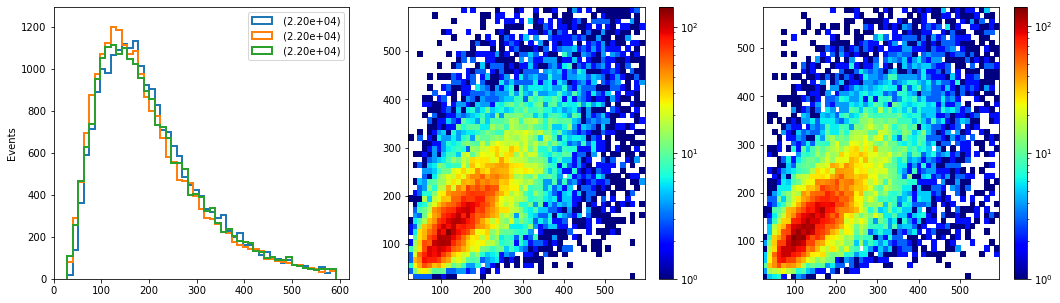

In [23]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
hist_multi([tx,ty,tz],figax=(fig,axs[0])); hist2d_simple(tz,tx,figax=(fig,axs[1])); hist2d_simple(tz,ty,figax=(fig,axs[2]));

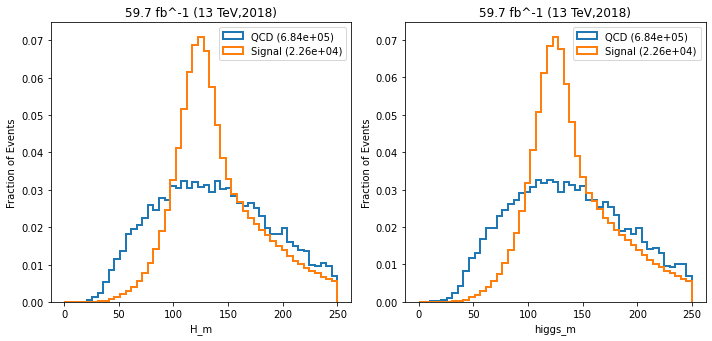

In [24]:
study.quick([qcd_tree,selection_full],varlist=["H_m","higgs_m"],binlist=[np.linspace(0,250,50)]*2,density=1)